# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.io import loadmat

# Tensorflow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
X_train, X_test = train['X'], test['X']
y_train, y_test = train['y'], test['y']

new_order = [3,0,1,2]
X_train = X_train.transpose(new_order)
X_test = X_test.transpose(new_order)

In [4]:
def rectify_labels(old_labels):
    corrected_labels = np.where(old_labels == 10, 0, old_labels) # replace 10 by 0
    return corrected_labels

In [5]:
y_train = rectify_labels(y_train)
y_test = rectify_labels(y_test)

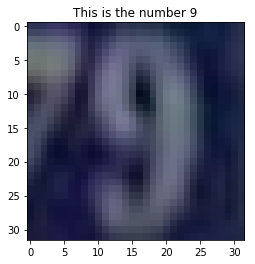

In [6]:
plt.imshow(X_train[35,:,:,:])
img_id = 'This is the number ' + str(y_train[35][0])
plt.title(img_id)
plt.show()

In [7]:
def show_images(X_data, y_data, num_figs):
    num_examples = X_data.shape[0]
    sample = np.random.choice(range(num_examples), size=num_figs)
    
    n_rows = int(math.ceil(num_figs / 10))
    gs = gridspec.GridSpec(n_rows, 10)
    fig = plt.figure(figsize=(18,4))
    
    for i,j in enumerate(sample):
        if X_data.shape[-1] == 3:
            image = X_data[j,:,:,:]
        elif X_data.shape[-1] == 1:
            image = X_data[j,:,:,0]
        else:
            raise ValueError('Wrong dimension of the input data...')            
        img_label = 'Number ' + str(y_data[j][0])    
        ax = fig.add_subplot(gs[i])
        ax.set_axis_off()
        ax.imshow(image)
        ax.set_title(img_label)
    
    plt.show()    

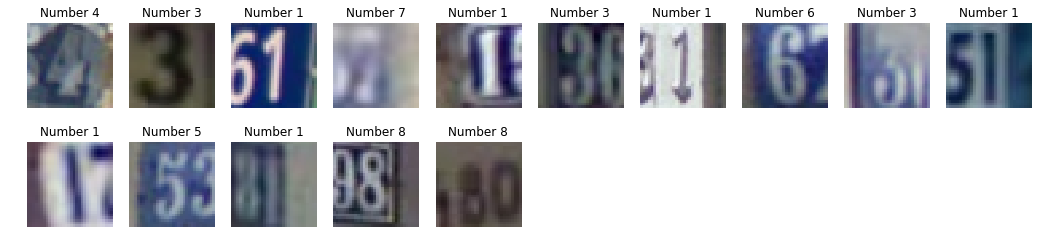

In [8]:
show_images(X_train, y_train, 15)

In [9]:
def average_colors(data):
    data_grayscale = np.average(data, axis = -1)[...,np.newaxis]
    return data_grayscale

In [10]:
X_train = average_colors(X_train)
X_test = average_colors(X_test)

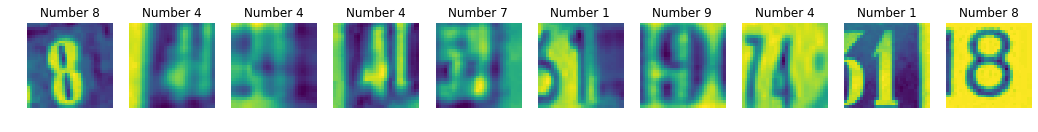

In [11]:
show_images(X_train, y_train, 10)

In [12]:
X_train = X_train / 255.0
X_test = X_test / 255.0

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [13]:
def leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.15)

def get_model(neurons_per_layers, wd, train_data):
    model = Sequential()
    for i, n_neurons in enumerate(neurons_per_layers):
        if i == 0:
            model.add(Flatten(input_shape=train_data.shape[1:]))
            model.add(Dense(n_neurons, kernel_regularizer=regularizers.l2(wd),
                            activation=leaky_relu))
        else:
            model.add(Dense(n_neurons, kernel_regularizer=regularizers.l2(wd),
                            activation=leaky_relu))
            
    model.add(Dense(10, activation='softmax', name="out_layer"))
    return model

In [14]:
nn_arch = [100, 50]
weight_decay = 1e-6
model = get_model(nn_arch, weight_decay, X_train)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               102500    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
out_layer (Dense)            (None, 10)                510       
Total params: 108,060
Trainable params: 108,060
Non-trainable params: 0
_________________________________________________________________


In [15]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer = opt, loss = loss, metrics = ['accuracy'])

In [16]:
def lr_decay(epoch, lr):
    if epoch <= 3:
        return lr
    else:
        lr = lr * np.exp(-1.5/epoch)
        return lr 

# learning schedule callback
lrate = LearningRateScheduler(lr_decay, verbose=1)
earlystop = EarlyStopping(patience=3)
mlp_checkpoint_best = 'nn_checkpoints_best/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=mlp_checkpoint_best, save_freq='epoch',
                                  save_weights_only=False, monitor='val_accuracy',
                                  save_best_only=True, verbose=1)

my_callbacks = [lrate, earlystop, checkpoint_best]

In [17]:
history = model.fit(X_train, y_train, epochs = 30, validation_split=0.15,
                    batch_size = 100, callbacks=my_callbacks, verbose = 1)

Train on 62268 samples, validate on 10989 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 1/30
61900/62268 [============================>.] - ETA: 0s - loss: 2.3114 - accuracy: 0.1861
Epoch 00001: val_accuracy improved from -inf to 0.21704, saving model to nn_checkpoints_best/checkpoint
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: nn_checkpoints_best/checkpoint/assets
62268/62268 [==============================] - 19s 312us/sample - loss: 2.3108 - accuracy: 0.1861 - val_loss: 2.1724 - val_accuracy: 0.2170

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 2/30
62200/62268 [============================>.] - ETA: 0s - loss: 1.9402 - accuracy: 0.3119 ETA: 1s
Epoch 00002: val_accuracy improved from 0.21704 to 0.43116, saving model to nn_checkpoints_best/checkpoint
INFO:tensorflow:Assets written to: nn_checkpoints_best/checkpoint/ass

In [18]:
df_hist = pd.DataFrame(history.history)
df_hist.head(10)

,loss,accuracy,val_loss,val_accuracy,lr
0,2.310797,0.186131,2.172417,0.217035,0.010000
1,1.939972,0.312070,1.629429,0.431158,0.010000
2,1.493482,0.501140,1.367031,0.561835,0.010000
3,1.326325,0.573232,1.309591,0.590773,0.010000
4,1.184806,0.630019,1.205127,0.630085,0.006873
5,1.090663,0.666602,1.111646,0.652835,0.005092
6,1.019994,0.693791,1.047261,0.684048,0.003965
7,0.959919,0.710863,0.970394,0.709619,0.003200
8,0.909784,0.728448,0.926577,0.717627,0.002653
9,0.872070,0.741874,0.889884,0.733461,0.002246


In [19]:
def plot_results(history):
    fig = plt.figure(figsize=(12, 5))

    fig.add_subplot(121)

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')

    fig.add_subplot(122)

    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='lower right')

    plt.show()

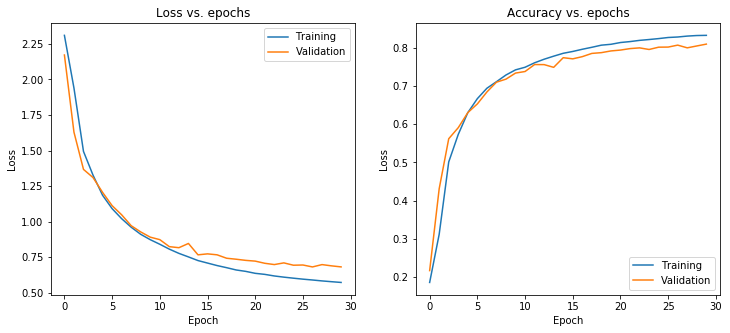

In [20]:
plot_results(df_hist)

In [21]:
def get_test_accuracy(model, X_test, y_test):
    test_loss, test_acc = model.evaluate(x=X_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))
    print('loss: {loss:0.3f}'.format(loss=test_loss))

get_test_accuracy(model, X_test, y_test) 

accuracy: 0.793
loss: 0.781


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [22]:
def get_cnn_model(train_data, wd, dprate, lr):
    model = Sequential()
    # Convolutional layers
    model.add(Conv2D(filters=24, kernel_size=(3,3), padding='SAME', activation='relu', 
                     input_shape = train_data.shape[1:], name='conv_1'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(dprate))
    
    model.add(Conv2D(filters=16, kernel_size=(3,3), padding='SAME', 
                     activation='relu', name='conv_2'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(BatchNormalization())
    model.add(Dropout(dprate*0.5))
    
    
    model.add(Flatten())
    # Fully connected layers
    model.add(Dense(50, activation=leaky_relu, kernel_regularizer=regularizers.l2(wd), name='fc_1'))
    
    # Output layer
    model.add(Dense(10, activation='softmax'))
    
    params = {'optimizer': tf.keras.optimizers.Adam(learning_rate=lr),
              'loss': tf.keras.losses.SparseCategoricalCrossentropy(),
              'metrics': ['accuracy']}
    
    model.compile(**params)
    
    return model

In [23]:
weight_decay = 1e-6
dropout_rate = 0.5
opt_lr = 0.01
cnn_model = get_cnn_model(X_train, weight_decay, dropout_rate, opt_lr)
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 24)        240       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 24)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 24)        96        
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 24)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 16, 16, 16)        3472      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 16)         

In [24]:
cnn_checkpoint_best = 'cnn_checkpoints_best/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=cnn_checkpoint_best, save_freq='epoch',
                                  save_weights_only=False, monitor='val_accuracy',
                                  save_best_only=True, verbose=1)

my_callbacks = [lrate, earlystop, checkpoint_best]

In [25]:
history = cnn_model.fit(X_train, y_train, epochs = 20, validation_split=0.15,
                        batch_size = 64, callbacks=my_callbacks, verbose = 1)

Train on 62268 samples, validate on 10989 samples

Epoch 00001: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 1/20
62208/62268 [============================>.] - ETA: 0s - loss: 1.0542 - accuracy: 0.6558
Epoch 00001: val_accuracy improved from -inf to 0.73273, saving model to cnn_checkpoints_best/checkpoint
INFO:tensorflow:Assets written to: cnn_checkpoints_best/checkpoint/assets
62268/62268 [==============================] - 283s 5ms/sample - loss: 1.0539 - accuracy: 0.6560 - val_loss: 0.8219 - val_accuracy: 0.7327

Epoch 00002: LearningRateScheduler reducing learning rate to 0.009999999776482582.
Epoch 2/20
62208/62268 [============================>.] - ETA: 0s - loss: 0.7037 - accuracy: 0.7795
Epoch 00002: val_accuracy improved from 0.73273 to 0.83347, saving model to cnn_checkpoints_best/checkpoint
INFO:tensorflow:Assets written to: cnn_checkpoints_best/checkpoint/assets
62268/62268 [==============================] - 277s 4ms/sample - loss: 0.7037 - ac

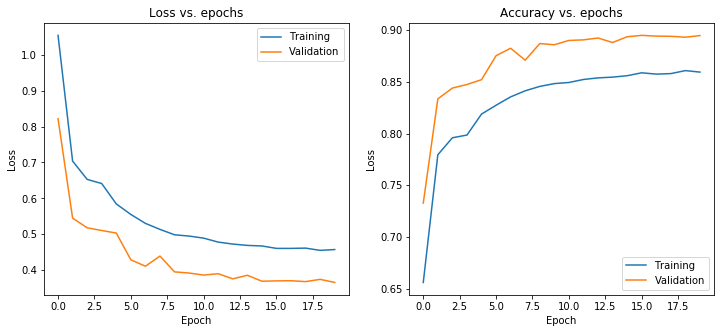

In [26]:
df_hist = pd.DataFrame(history.history)
plot_results(df_hist)

In [27]:
def get_test_accuracy(model, X_test, y_test):
    test_loss, test_acc = model.evaluate(x=X_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))
    print('loss: {loss:0.3f}'.format(loss=test_loss))

get_test_accuracy(cnn_model, X_test, y_test) 

accuracy: 0.886
loss: 0.395


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [28]:
MLP_model = load_model(mlp_checkpoint_best)
CNN_model = load_model(cnn_checkpoint_best)

In [29]:
num_examples = X_test.shape[0]
sample = np.random.choice(range(num_examples), size=6)
X6_test = X_test[sample]
y6_true_labels = y_test[sample]
y6_pred_mlp = MLP_model.predict(X6_test)
y6_pred_cnn = CNN_model.predict(X6_test)

In [30]:
def plot_predictions(n_rows, n_cols, test_images, y_true, y_pred):
    
    plt.figure(figsize=(20, 15))
    n = 0
    for i in range(1,n_rows*n_cols+1): # Displaying 6 samples
        
        if i%2 != 0:
            plt.subplot(n_rows, n_cols, i)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(test_images[n][:,:,0], cmap='gray') # Plot image selected from test sample
            true_label = y_true[n]
            plt.title('True {}'.format(true_label)) # Dsiplaying Label
            
        else:
            plt.subplot(n_rows, n_cols, i)
            plt.bar(range(10), y_pred[n].flatten())
            plt.ylim([0, 1])
            pred_label = np.argmax(y_pred[n])
            plt.title('Predicted {}'.format(pred_label)) # Dsiplaying Label
            n += 1
            
    plt.show()        

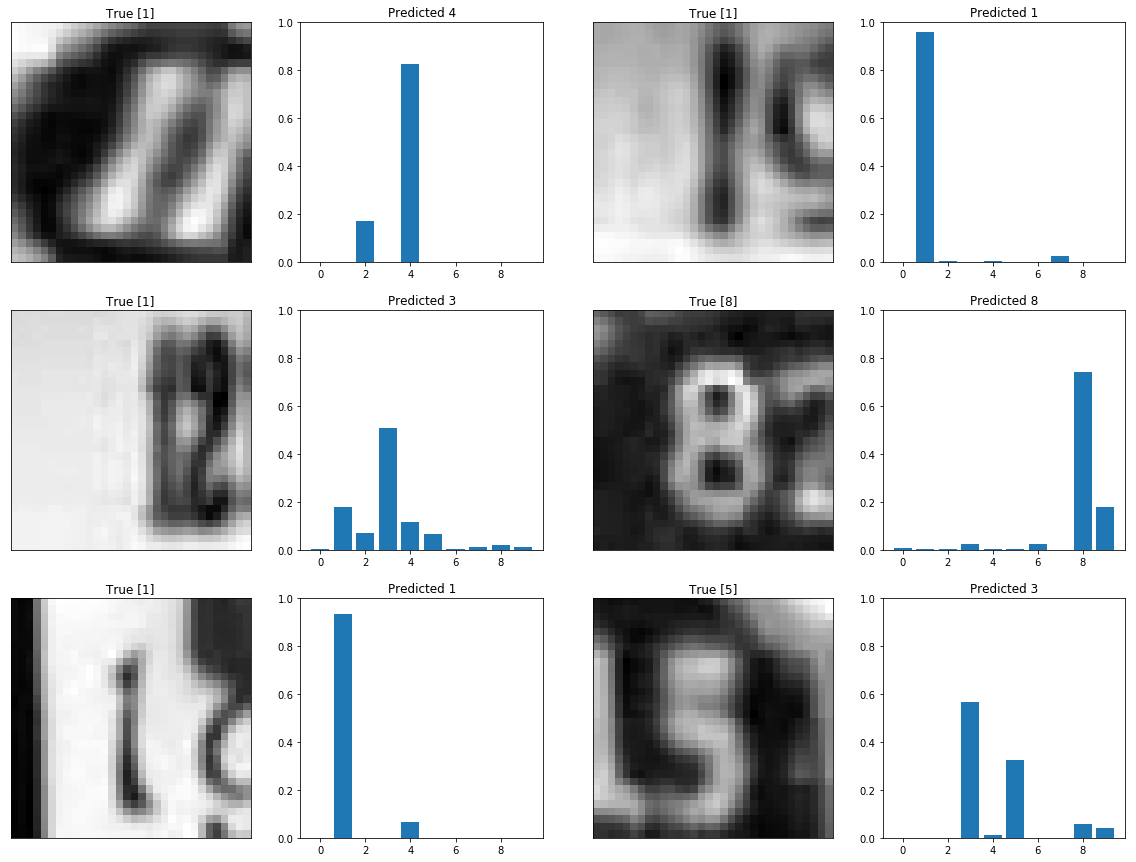

In [31]:
plot_predictions(3, 4, X6_test, y6_true_labels, y6_pred_mlp)

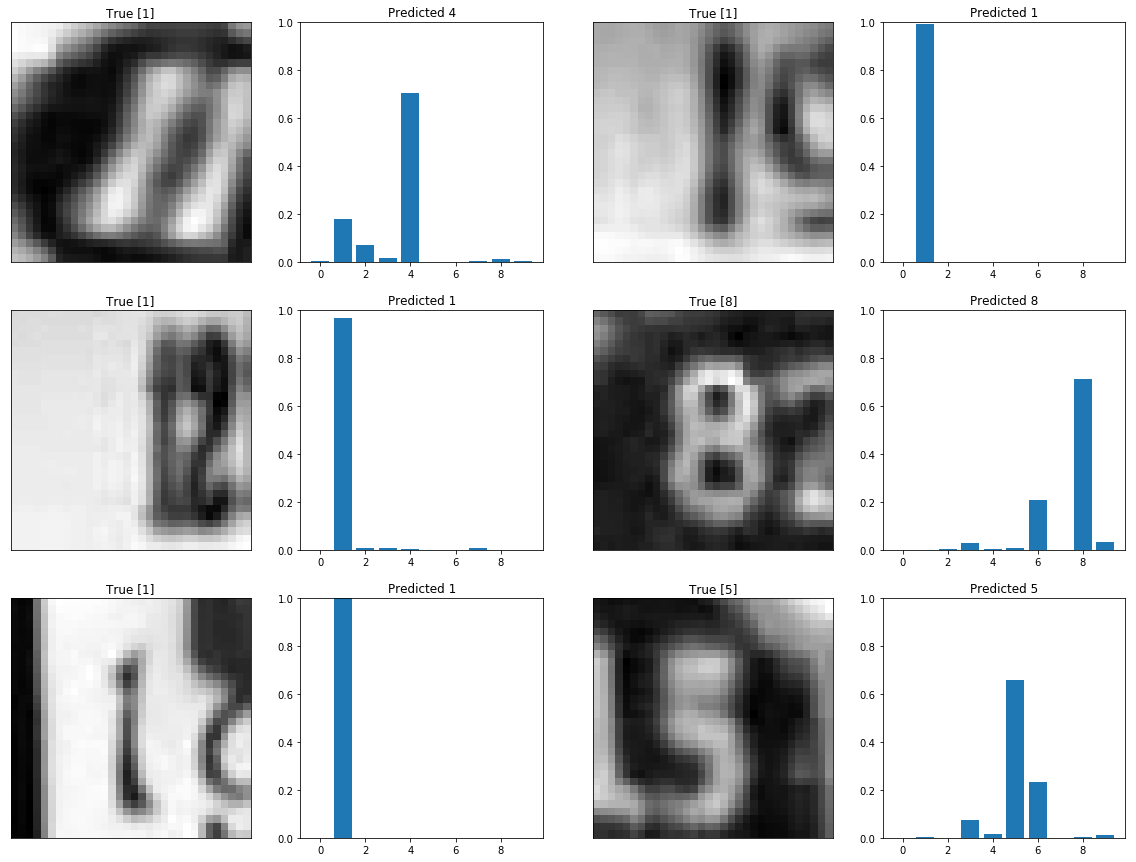

In [32]:
plot_predictions(3, 4, X6_test, y6_true_labels, y6_pred_cnn)

In [33]:
y_pred_mlp = MLP_model.predict(X_test)
y_pred_cnn = CNN_model.predict(X_test)

In [34]:
# Convert the true labels and predicted labels into binary matrices,
# where the hot index (ones) indicates the actual class
y_pred_mlp_bin = np.zeros(y_pred_mlp.shape)
y_pred_mlp_bin[np.arange(len(y_pred_mlp)), y_pred_mlp.argmax(1)] = 1

y_pred_cnn_bin = np.zeros(y_pred_cnn.shape)
y_pred_cnn_bin[np.arange(len(y_pred_cnn)), y_pred_cnn.argmax(1)] = 1

mlb = MultiLabelBinarizer()
y_test_bin = mlb.fit_transform(y_test)

In [35]:
def cm_plot(y_true, y_pred, labels, ymap=None, cmap='BuPu', figsize=(16,12)):
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c <= 0.5:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Real'
    cm.columns.name = 'Prediction'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, linewidth=0.2, cmap = cmap)
    plt.ylim(len(cm)+0.05, -0.05)
    plt.show()

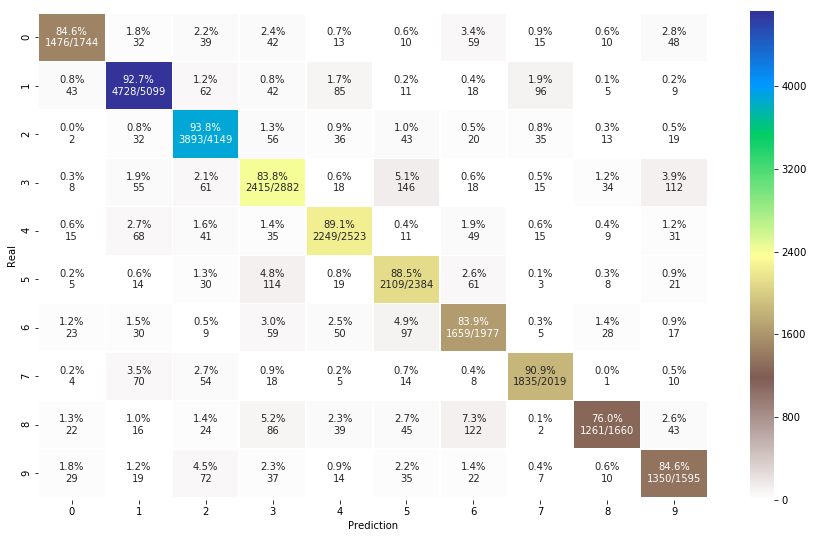

In [36]:
cm_plot(y_test_bin.argmax(axis=1), y_pred_cnn_bin.argmax(axis=1), labels=None, ymap=None, 
        cmap='terrain_r', figsize=(15,9))